# Working With Units (adapted from Metpy Units Tutorial)

Early in our scientific careers we all learn about the importance of paying
attention to units in our calculations. Unit conversions can still get the best
of us and have caused more than one major technical disaster, including the
crash and complete loss of the $327 million Mars Climate Orbiter.

In MetPy, we use the [pint](https://pint.readthedocs.io/en/stable/developers_reference.html#module-pint)
library and a custom unit registry to help prevent
unit mistakes in calculations. That means that every quantity you pass to MetPy
should have units attached, just like if you were doing the calculation on
paper! This simplifies the MetPy API by eliminating the need to specify units
in various functions. Instead, only the final results need to be converted to desired units. For
more information on unit support, see the documentation for
[Pint](https://pint.readthedocs.io). Particular attention should be paid to the support
for [temperature units](https://pint.readthedocs.io/en/latest/nonmult.html).

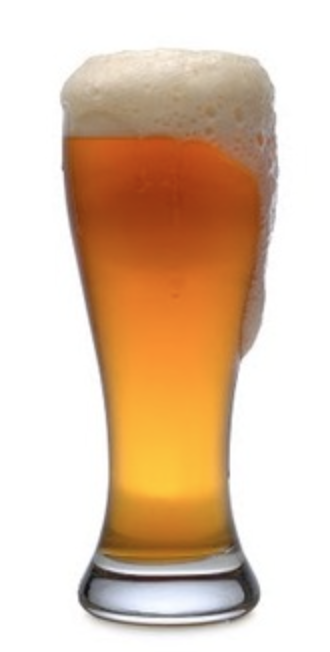

In this notebook we'll show some examples of working with units and get you on your way to
utilizing the computation functions in MetPy.


## Getting Started
To use units, the first step is to import the default MetPy units registry from the
:mod:`~metpy.units` module:



In [3]:
import numpy as np

import metpy.constants as mpconst
from metpy.units import units

The unit registry encapsulates all of the available units, as well as any pertinent settings.
The registry also understands unit prefixes and suffixes; this allows the registry to
understand ``'kilometer'`` and ``'meters'`` in addition to the base ``'meter'`` unit.

In general, using units is only a small step on top of using the `numpy.ndarray`
object.

## Adding Units to Data
The easiest way to attach units to an array (or integer, float, etc.) is to multiply by the
units:



In [5]:
distance = 

It is also possible to directly construct a `pint.Quantity`, with a full units string:



Compound units can be constructed by the direct mathematical operations necessary:



This verbose syntax can be reduced by using the unit registry's support for parsing units:



## Operations With Units
With units attached, it is possible to perform mathematical operations, resulting in the
proper units:



For multiplication and division, units can combine and cancel. For addition and subtraction,
instead the operands must have compatible units. For instance, this works:



But for instance, `distance + time` would not work; instead it gives an error:

`DimensionalityError: Cannot convert from 'meter' ([length]) to 'second' ([time])`

Even if the units are not identical, as long as they are dimensionally equivalent, the
operation can be performed:



## Converting Units

Converting a `Quantity` between units can be accomplished by using the
`Quantity.to` method call, which constructs a new `Quantity` in the
desired units:



There is also the `Quantity.ito` method which performs the same operation
in-place:



In [ ]:
# 👣

To simplify units, there is also the `Quantity.to_base_units` method,
which converts a quantity to SI units, performing any needed cancellation:



In [ ]:
Lf = 

`Quantity.to_base_units` can also be done in-place via the
`Quantity.ito_base_units` method.

By default Pint does not do any more than simple unit simplification, so when you perform
operations you could get some seemingly odd results:



This is another place where `Quantity.to` comes in handy:



$$
52 \, \text{cm} \left( \frac{1 \, \text{m}}{100 \, \text{cm}} \right) \cdot 1 \, \text{inch} \left( \frac{2.54\,\text{cm}}{\text{inch}} \right) \cdot \left( \frac{1\,\text{m}}{100\,\text{cm}} \right)
$$
``

## Temperature
Temperature units are actually relatively tricky (more like absolutely tricky as
you'll see). Temperature is a non-multiplicative unit - they are in a system
with a reference point. That means that not only is there a scaling factor, but
also an offset. This makes the math and unit book-keeping a little more complex.
Imagine adding 10 degrees Celsius to 100 degrees Celsius. Is the answer 110
degrees Celsius or 383.15 degrees Celsius (283.15 K + 373.15 K)? That's why
there are delta degrees units in the unit registry for offset units. For more
examples and explanation you can watch MetPy Monday #13:
https://www.youtube.com/watch?v=iveJCqxe3Z4.

Let's take a look at how this works and fails:

We would expect this to fail because we cannot add two offset units (and it does
fail as an "Ambiguous operation with offset unit").

`10 * units.degC + 5 * units.degC`

On the other hand, we can subtract two offset quantities and get a delta. A delta unit is
pint's way of representing a relative change in two offset units, indicating that this is
not an absolute value of 5 degrees Celsius, but a relative change of 5 degrees Celsius.



We can add a delta to an offset unit as well since it is a relative change.



$$
\degree F = \left(\frac{9}{5}\right) \degree C + 32 \implies F_1 - F_2 = \left(\frac{9}{5}\right) (C_1 - C_2) \text{ thus } \delta \degree F = \left(\frac{9}{5}\right) \delta \degree C
$$
``

Absolute temperature scales like Kelvin and Rankine do not have an offset
and therefore can be used in addition/subtraction without the need for a
delta version of the unit.



## Strip Units from Array

Not everything currently handles the fact that there are units attached to arrays, so there is a method to get just the values of an array by appending *.magnitude* to the end of the variable name.

This is called the manitude of the array and can be obtained with the following call:

```<variable_name>.magnitude```

or

```<variable_name>.m```

## Common Mistakes
There are a few common mistakes the new users often make. Be sure to check
these when you're having issues.

* Pressure units are `mbar` or `hPa` for common atmospheric measurements. The
  unit `mb` is actually millibarns--a unit used in particle physics.
* When using masked arrays, units must be multiplied on the left side. This
  will be addressed in the future, but is a current limitation in the
  ecosystem. The expected error will be
  `AttributeError: 'MaskedArray' object has no attribute 'units'` or calculation
  functions complaining about expecting a units and getting "dimensionless".



## Meteorological Calculation with Units
While there are many calculations that have been contributed to MetPy, there are plenty of calculations that we do that are not captured, but where we can use a combination of MetPy constants and units along with our knowledge of any needed equations to perform calculations in a Jupyter Notebook. Here we'll demonstrate a calculation of the Rossby 500-hPa wave speed common in synoptic meteorology.

### MetPy Constants
We deal with a lot of constants in meteorology when doing calculations, whether that is Earth's radius ($R_e$), dry air gas constant ($R_d$), specific heat of air ($C_p$), etc. MetPy has captured and reference these values with units that can be utilized in calculations. For a full list of the available constants and to see their references go to:

https://unidata.github.io/MetPy/latest/api/generated/metpy.constants.html

### Rossby Wave Speed Calculation

Now let's do an example caluclation. We will calculate the speed of a 500-hPa Rossby wave (just think of a commone midlevel trough/ridge patter, that is the type of wave we are looking to estimate their movement speed.

The equation for the speed of a Rossby wave is:

$\large c = U - \beta(\frac{\lambda}{2\pi})^2$

where

$\large c$: is the Rossby wave speed (what we are looking to calculated)

$\large U$: is the upper-level wind speed (given by observations)

$\large \beta$: is the gradient of Coriolis around a latitude (e.g., $~1.75*10^{-11}$ $m^{-1}$ $s^{-1}$ at 40N)

$\large \beta = \frac{df}{dy} = \frac{2 \Omega}{a}cos(\phi)$: where $a$ is the radius of Earth = 6378 km and $\Omega = 7.292*10^{-5} s^{-1}$

$\large \lambda$: is the wavelength of the wave

We can set up a series of variables with units attached and some MetPy constants to come up with our estimate of the speed of the Rossby wave.  From Holton's textbook on Dynamic Meteorology (Fig. 5.14, page 160).  
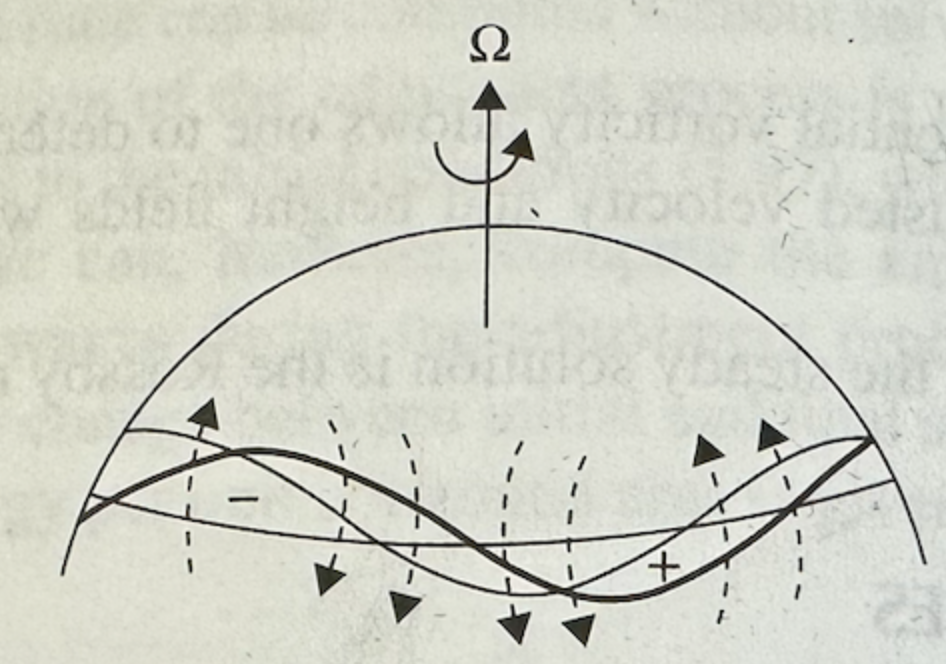

Calculation of *df/dy*
$$
f = 2\Omega \sin \phi \Rightarrow \frac{df}{dy} = \frac{d}{dy}(2\Omega \sin \phi) = 2\Omega \cdot \frac{d}{dy} (\sin \phi) = 2\Omega (\cos \phi) \frac{d\phi}{dy}
$$

Where
$$
r_e \, d\phi = dy \Rightarrow \frac{df}{dy} = \frac{2\Omega \cos\phi}{r_e}
$$

In [ ]:
#Let's do this with units


In [ ]:
#Define constants...
#Earth radius

#Earth angular rotation rate (86400s/2*pi)


In [ ]:
#Calculate beta = df/dy (scale analysis)


DRL Sanity check - scale analysis for *df/dy*!

$$
\frac{df}{dy} = \frac{2\Omega \cos \phi}{r_e} \sim \frac{10^{-4}}{10^7} \sim 10^{-11}
$$


In [ ]:
#Same answer


In [ ]:
# What if we used the following instead, without the units? 


In [ ]:
#This doesn't work!


In [ ]:
#OK, party over 🎉, let's calculate the Rossby phase speed...
